<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from IPython.core.display import display, HTML
from time import sleep
from folium.plugins import MarkerCluster
%matplotlib inline

In [21]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: middle;
    vertical-align: middle;
}
</style>
""")

# <center>Providence Crime Data April through August 2017</center>

I decided to look to the open data portal provided by the city of Providence to find a dataset for the EDX Python for Data Science final project. Providence provides a dataset of state and municipal offenses from AEGIS records management system of the Providence Police. Unfortunately this dataset only contains the last 180 days of case logs. While not ideal, this an introduction course, and one of the first data projects I worked on, so I decided it would still be worth looking at. My first question after looking at the data set: when do crimes happen in Providence?

In [22]:
pvd_crimes = pd.read_csv("PVD_Crimes_10_08_17")

In [23]:
pvd_crimes.groupby("offense_desc").count().sort_values('counts', ascending = False).head(10)
top_crimes = ["Vandalism", "Assault, Simple", "Larceny from Motor Vehicle", "Traffic Violation", "Larceny, Other", 
             "RI Statute Violation", "Burglary", "Disorderly Conduct"]

In [24]:
crime_counts_by_hour = pvd_crimes.groupby(["offense_desc", "hour"]).count()
crime_counts_by_hour = crime_counts_by_hour["counts"]

First, a look at the hourly crime rate for the 9 most common crimes. (I did exclude “Missing Persons” as I was unsure about how this crime was usually reported.)

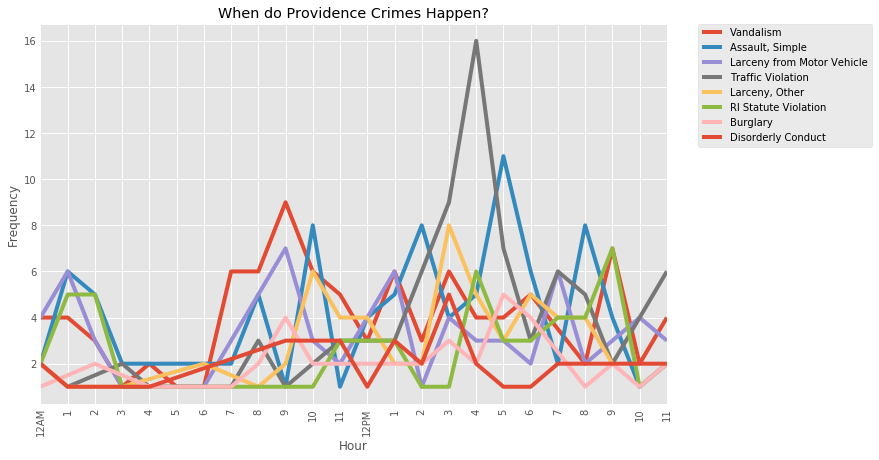

In [25]:
plt.figure(figsize=(10, 7))

plt.style.use('ggplot')

for crime in top_crimes:
    crime_counts_by_hour.loc[crime].plot()
plt.legend(top_crimes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(np.arange(24), ("12AM", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12PM", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"),  rotation='vertical')

plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('When do Providence Crimes Happen?')

plt.show();

The drop in all crime between 3am and 6am is expected, as is the jumpy in traffic violations between 4pm and 5pm when students and members of the workforce begin traveling home for the day. There’s a slight peak around 9am in most crimes, but the data is too noisy and not robust enough for any trends to present themselves. I would like to group similar crimes together into a few categories, but that was beyond the time I had for this project. 

In [26]:
crime_counts_by_month = pvd_crimes[pvd_crimes["month"] != 10]
crime_counts_by_month = crime_counts_by_month[crime_counts_by_month["month"] != 9]
crime_counts_by_month = crime_counts_by_month.groupby(["offense_desc", "month"]).count()
crime_counts_by_month = crime_counts_by_month["counts"]

Looking at the same top crimes, and what their distribution is over the last 5 months. 

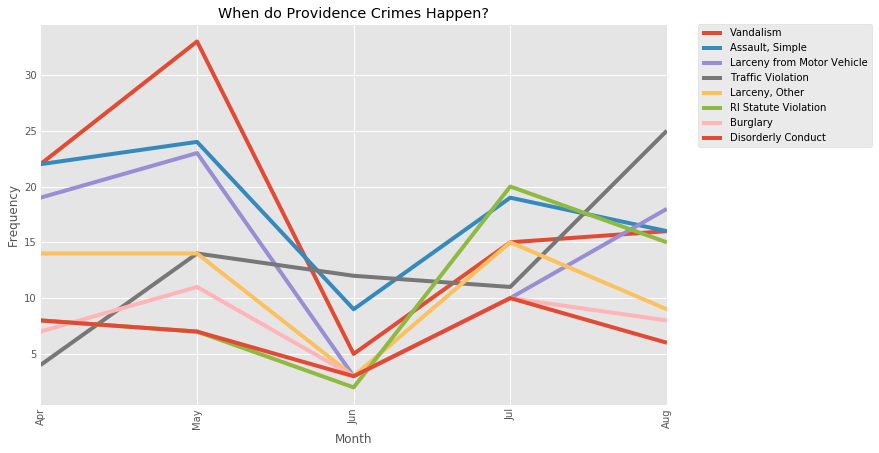

In [27]:
plt.figure(figsize=(10, 7))


plt.style.use('ggplot')

for crime in top_crimes:
    crime_counts_by_month.loc[crime].plot()
    
plt.legend(top_crimes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.xticks([4,5,6,7,8], ("Apr", "May", "Jun", "Jul", "Aug"),  rotation='vertical')

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('When do Providence Crimes Happen?')

plt.show();

There is a noticeable spike in all the top crimes in June. Do criminals take vacations? The frequency doesn’t rebound to quite the same level in July as in May, but it’s close enough that June looks like a real outlier.

In [28]:
crime_counts = pvd_crimes.groupby("offense_desc", as_index=False).count()[["offense_desc","counts"]]
crime_counts_plot = crime_counts.sort_values('counts', ascending = False).head(10)
crime_counts_plot = crime_counts_plot.sort_values("counts", ascending = True)

I’ve been looking at 9 of the most common crimes in Providence and the last 180 days and thought it would be useful to visualize that. 

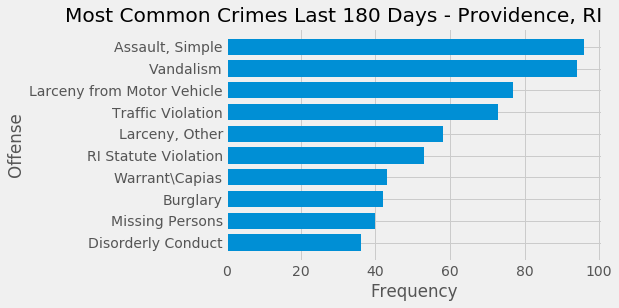

In [29]:
plt.style.use('fivethirtyeight')

offense = crime_counts_plot["offense_desc"]
frequencies = crime_counts_plot["counts"]

pos = np.arange(len(offense))
width = 0.75     # gives histogram aspect to the bar diagram

ax = plt.axes()
ax.set_yticks(pos)
ax.set_yticklabels(offense)

plt.barh(pos, frequencies, width)

plt.xlabel('Frequency')
plt.ylabel('Offense')
plt.title('Most Common Crimes Last 180 Days - Providence, RI', loc ="right")

plt.show();

Vandalism and Simple, Assault lead the way, followed by Larceny from a Motor Vehicle(which I’ve had happen) and Traffic Violations coming in a close 3rd and 4th. An RI Statute Violation seems to be a sort of catchall for a broken law, but I couldn’t find an explanation on the PVD Police Department’s website.

Finally, I decided to map the crimes to see where they occur the most often.

In [30]:
PVD_Coor = (41.824, -71.4128)

pvd_map = folium.Map(location=PVD_Coor, tiles='CartoDB positron', zoom_start=12);

#add a marker for every record in the filtered data, use a clustered view
marker_cluster = MarkerCluster().add_to(pvd_map);


for i in range(0, len(pvd_crimes)):
    folium.Marker(location = [pvd_crimes["lat"][i], pvd_crimes["lon"][i]] , 
                  popup=str(pvd_crimes['offense_desc'][i])+' '+str(pvd_crimes['reporting_officer'][i]),
                  icon=folium.Icon(color='darkblue')).add_to(marker_cluster)
    
pvd_map.save("PvdCrime.html")

In [23]:
%%HTML

<iframe width = "100%" height = "600" src="http://pvdcrimemap.x10host.com/PvdCrime.html"></iframe>

The map fits the general narrative of the city, that is that there is less crime on the East Side, more in the general downtown area, with the most occurring on the West Side and in Southern Providence. The map is explorable and when zooming in you can see situations where multiple (sometimes many) violations were booked at the same location.

I’m glad the city of Providence is releasing this data, but I think I would be beneficial for the city to keep record of and release data on all crime logs instead of limiting the available data set to the last 180 days. Providence has an opportunity to lead the nation in providence citizens with robust open data and I hope one day the city sees that and lives up to the possibility. 

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter, delivered by Fastly, rendered by Rackspace.
</footer>